## Imports and Constants

In [539]:
import os
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ["KMP_AFFINITY"] = "noverbose"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
tf.autograph.set_verbosity(3)

from PIL import Image
import random

from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [493]:
DATAPATH = '../data/dataset/'
MODELPATH = os.path.join(DATAPATH, 'humans/')
TOPSPATH = os.path.join(DATAPATH, 'tops/')
ONEPIECEPATH = os.path.join(DATAPATH, 'onepiece/')
SAVEDMODEL = os.path.join(DATAPATH, 'saved_model/')

## Load Data
### Load Models

In [494]:
models = pd.read_json(os.path.join(MODELPATH, 'model.json'))

In [495]:
models = models.transpose()
models

,height,bust,waist,hips,url
Alex,174.0,81.0,64.0,91.0,https://birdsnest-images.imgix.net/system/imag...
Amanda,178.0,86.0,67.0,89.0,https://birdsnest-images.imgix.net/system/imag...
Anna,175.0,84.0,72.0,98.0,https://birdsnest-images.imgix.net/system/imag...
Anna Maria,179.0,84.0,64.0,90.0,https://birdsnest-images.imgix.net/system/imag...
Anneliese,178.0,84.0,64.0,91.0,https://images.prismic.io/birdsnest-blog/0f008...
...,...,...,...,...,...
Stacey,169.0,101.0,80.0,98.0,https://birdsnest-images.imgix.net/system/imag...
Stefania,172.0,97.0,73.0,103.0,https://birdsnest-images.imgix.net/system/imag...
Summer,176.0,84.0,64.0,96.0,https://birdsnest-images.imgix.net/system/imag...
Thais,178.0,86.5,61.0,92.5,https://birdsnest-images.imgix.net/system/imag...


In [496]:
fp = os.path.join(MODELPATH, 'humans.csv')
models.to_csv(fp, index=False)

### Load the Tops

In [497]:
def parse_json(filepath):
    with open(filepath, 'r') as f:
        json_data = json.load(f)
    f.close()

    name = filepath.split('/')[-1].split('.')[0]
    
    try:
        keys = list(json_data.keys())
    except:
        return None


    data = []
    for size in keys:
        dims_data = {} # creating a dictionary for each clothing size, easier to work with
        dims_data['name'] = name
        dims_data['size'] = size

        for dim in json_data[size]:
            dims_data[dim["dimension_name"]] = dim["value"]

        data.append(dims_data)
    
    return data

In [498]:
dirpath = os.path.join(TOPSPATH, 'garment_measurement')

data = []
count = 0
not_parsed = []

for file in os.listdir(dirpath):
    if file.endswith('.txt'):
        filepath = os.path.join(dirpath, file)

    data_ = parse_json(filepath)
    if data_ is None:
        count += 1
        not_parsed.append(filepath)
        continue
    
    for d in data_:
        data.append(d)

In [499]:
print(f"Number of files not parsed: {count}")

Number of files not parsed: 126


In [500]:
tops = pd.DataFrame(data)
tops = tops.sort_values(by=['name']).reset_index(drop=True)
tops

,name,size,Length - shoulder to hem,Sleeve Length - neck to hem,Hip,Bust,Waist,Length - waist to hem
0,2-in-1-jumper#Navy_meta,M,71-75cm,65cm,126cm,120cm,118cm,NaN
1,2-in-1-layered-knit-top#Khaki_meta,M,61-70cm,56cm,138cm,114cm,124cm,NaN
2,2-in-1-layered-knit-top#Navy_meta,M,61-70cm,56cm,138cm,114cm,124cm,NaN
3,2-in-1-layered-knit-top#PalePink_meta,M,61-70cm,56cm,138cm,114cm,124cm,NaN
4,2-in-1-layered-top-1#NavyWhite_meta,M,67cm,67cm,140cm,120cm,NaN,NaN
...,...,...,...,...,...,...,...,...
3823,yvette-blouse#Black_meta,8,NaN,38cm,127cm,NaN,96cm,NaN
3824,yvette-blouse#Black_meta,10,NaN,39cm,132cm,NaN,100cm,NaN
3825,yvette-blouse#Black_meta,16,NaN,42cm,147cm,NaN,112cm,NaN
3826,yvette-blouse#Black_meta,18,NaN,43cm,152cm,NaN,116cm,NaN


In [501]:
tops.columns

Index(['name', 'size', 'Length - shoulder to hem',
       'Sleeve Length - neck to hem', 'Hip', 'Bust', 'Waist',
       'Length - waist to hem'],
      dtype='object')

In [502]:
tops = tops.drop('Length - waist to hem', axis=1)

In [503]:
tops

,name,size,Length - shoulder to hem,Sleeve Length - neck to hem,Hip,Bust,Waist
0,2-in-1-jumper#Navy_meta,M,71-75cm,65cm,126cm,120cm,118cm
1,2-in-1-layered-knit-top#Khaki_meta,M,61-70cm,56cm,138cm,114cm,124cm
2,2-in-1-layered-knit-top#Navy_meta,M,61-70cm,56cm,138cm,114cm,124cm
3,2-in-1-layered-knit-top#PalePink_meta,M,61-70cm,56cm,138cm,114cm,124cm
4,2-in-1-layered-top-1#NavyWhite_meta,M,67cm,67cm,140cm,120cm,NaN
...,...,...,...,...,...,...,...
3823,yvette-blouse#Black_meta,8,NaN,38cm,127cm,NaN,96cm
3824,yvette-blouse#Black_meta,10,NaN,39cm,132cm,NaN,100cm
3825,yvette-blouse#Black_meta,16,NaN,42cm,147cm,NaN,112cm
3826,yvette-blouse#Black_meta,18,NaN,43cm,152cm,NaN,116cm


In [504]:
tops.dropna(inplace=True)
tops.reset_index(drop=True, inplace=True)

In [505]:
tops

,name,size,Length - shoulder to hem,Sleeve Length - neck to hem,Hip,Bust,Waist
0,2-in-1-jumper#Navy_meta,M,71-75cm,65cm,126cm,120cm,118cm
1,2-in-1-layered-knit-top#Khaki_meta,M,61-70cm,56cm,138cm,114cm,124cm
2,2-in-1-layered-knit-top#Navy_meta,M,61-70cm,56cm,138cm,114cm,124cm
3,2-in-1-layered-knit-top#PalePink_meta,M,61-70cm,56cm,138cm,114cm,124cm
4,34-sleeve-shirt-1#SkyWhite_meta,12,83cm,59cm,106cm,96cm,96cm
...,...,...,...,...,...,...,...
1829,wrap-me-up-bamboo-top#BlueJeans_meta,14,63cm,62cm,97cm,109cm,95cm
1830,wrap-me-up-bamboo-top#BlueJeans_meta,22,67cm,66cm,117cm,129cm,115cm
1831,york-linen-blend-long-cardigan#BurntOrang_meta,M,116cm,76cm,110cm,120cm,110cm
1832,york-linen-blend-top#BurntOrang_meta,M,62cm,65cm,98cm,106cm,100cm


In [506]:
fp = os.path.join(TOPSPATH, 'tops_meas.csv')
tops.to_csv(fp, index=False)

In [507]:
tops.describe()

,name,size,Length - shoulder to hem,Sleeve Length - neck to hem,Hip,Bust,Waist
count,1834,1834,1834,1834,1834,1834,1834
unique,627,22,146,83,150,118,127
top,the-wrap-jersey-top#JetBlack_meta,12,65cm,70cm,110cm,104cm,110cm
freq,9,430,84,115,64,73,82


### Load Onepiece

In [508]:
dirpath = os.path.join(ONEPIECEPATH, 'garment_measurement')

data = []
count = 0
not_parsed = []

for file in os.listdir(dirpath):
    if file.endswith('.txt'):
        filepath = os.path.join(dirpath, file)

    data_ = parse_json(filepath)
    if data_ is None:
        count += 1
        not_parsed.append(filepath)
        continue
    
    for d in data_:
        data.append(d)

In [509]:
print(f"Number of files not parsed: {count}")

Number of files not parsed: 0


In [510]:
onepiece = pd.DataFrame(data)
onepiece = onepiece.sort_values(by=['name']).reset_index(drop=True)
onepiece

,name,size,Bust,Waist,Hip,Length - shoulder to hem,Length - waist to hem,Sleeve Length - neck to hem
0,2-in-1-dress-1#Navy_meta,12,96cm,100cm,114cm,97cm,NaN,65cm
1,34-sleeve-cross-over-dress-1#Black_meta,14,94cm,70cm,NaN,102cm,NaN,51cm
2,34-sleeve-cross-over-dress-1#Black_meta,12,91cm,65cm,NaN,101cm,NaN,51cm
3,34-sleeve-cross-over-dress-1#Navy_meta,12,91cm,65cm,NaN,101cm,NaN,51cm
4,34-sleeve-cross-over-dress-1#Navy_meta,14,94cm,70cm,NaN,102cm,NaN,51cm
...,...,...,...,...,...,...,...,...
2988,zett-dress#EdenBlack_meta,3,88cm,102cm,124cm,99cm,NaN,18cm
2989,zinnia-dress-1#PrimaveraC_meta,3,92cm,74cm,108cm,146cm,105cm,26cm
2990,zip-front-floral-printed-dress#Mulit_meta,12,88cm,84cm,118cm,88-130cm,88cm,9cm
2991,zoe-dress-3#AutumnTape_meta,M,90cm,90cm,102cm,91cm,NaN,65cm


In [511]:
onepiece.columns

Index(['name', 'size', 'Bust', 'Waist', 'Hip', 'Length - shoulder to hem',
       'Length - waist to hem', 'Sleeve Length - neck to hem'],
      dtype='object')

In [512]:
onepiece.dropna(inplace=True)
onepiece.reset_index(drop=True, inplace=True)

In [513]:
onepiece

,name,size,Bust,Waist,Hip,Length - shoulder to hem,Length - waist to hem,Sleeve Length - neck to hem
0,a-nice-cotton-dress#Strawberry_meta,OneSize,170cm,170cm,170cm,94cm,48cm,35cm
1,a-star-is-born-dress#Rouge_meta,12,84cm,76cm,192cm,100cm,61cm,40cm
2,alexis-dress-2#Amalfi_meta,M,102cm,106cm,124cm,144cm,96cm,28cm
3,alicia-maxi-dress#Black_meta,12,86cm,70cm,130cm,153cm,115cm,31cm
4,alicia-maxi-dress#Charcoal_meta,12,86cm,70cm,130cm,153cm,115cm,31cm
...,...,...,...,...,...,...,...,...
953,wrapped-bouquet-dress-2#DustyPink_meta,10,92cm,82cm,126cm,121cm,76cm,45cm
954,wrapped-bouquet-dress-2#DustyPink_meta,8,86cm,76cm,120cm,121cm,76cm,44cm
955,zebra-dress-3#NemoRed_meta,M,106cm,114cm,116cm,97cm,50cm,47cm
956,zinnia-dress-1#PrimaveraC_meta,3,92cm,74cm,108cm,146cm,105cm,26cm


In [514]:
fp = os.path.join(ONEPIECEPATH, 'onepiece_meas.csv')
onepiece.to_csv(fp, index=False)

## Standardization

In [515]:
models.drop(columns=['url'], inplace=True)
model_dict = models.to_dict('index')
model_dict

{'Alex': {'height': '174.0', 'bust': '81.0', 'waist': '64.0', 'hips': '91.0'},
 'Amanda': {'height': '178.0',
  'bust': '86.0',
  'waist': '67.0',
  'hips': '89.0'},
 'Anna': {'height': '175.0', 'bust': '84.0', 'waist': '72.0', 'hips': '98.0'},
 'Anna Maria': {'height': '179.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '90.0'},
 'Anneliese': {'height': '178.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '91.0'},
 'Bree': {'height': '180.0', 'bust': '99.0', 'waist': '72.0', 'hips': '107.0'},
 'Charlotte': {'height': '169.0',
  'bust': '88.0',
  'waist': '67.0',
  'hips': '93.0'},
 'Chesska': {'height': '173.0',
  'bust': '89.0',
  'waist': '69.0',
  'hips': '94.0'},
 'Chelsea': {'height': '177.0',
  'bust': '84.0',
  'waist': '69.0',
  'hips': '96.0'},
 'Clementine': {'height': '175.0',
  'bust': '86.0',
  'waist': '65.0',
  'hips': '91.0'},
 'Denniel': {'height': '178.0',
  'bust': '94.0',
  'waist': '71.0',
  'hips': '91.0'},
 'Edith': {'height': '175.0',
  'bust': '84.0',
 

In [516]:
model_stats = np.zeros((len(model_dict), 4))
for i in enumerate(model_dict):
    model_stats[i[0]] = np.array(list(model_dict[i[1]].values()))
model_stats

array([[174. ,  81. ,  64. ,  91. ],
       [178. ,  86. ,  67. ,  89. ],
       [175. ,  84. ,  72. ,  98. ],
       [179. ,  84. ,  64. ,  90. ],
       [178. ,  84. ,  64. ,  91. ],
       [180. ,  99. ,  72. , 107. ],
       [169. ,  88. ,  67. ,  93. ],
       [173. ,  89. ,  69. ,  94. ],
       [177. ,  84. ,  69. ,  96. ],
       [175. ,  86. ,  65. ,  91. ],
       [178. ,  94. ,  71. ,  91. ],
       [175. ,  84. ,  66. , 101. ],
       [174. ,  81. ,  64. ,  91. ],
       [175. ,  83. ,  71. ,  99. ],
       [181. , 101. ,  83. , 115. ],
       [176. ,  86.5,  70. ,  91.5],
       [170. ,  81. ,  61. ,  89. ],
       [172. ,  86. ,  66. ,  99. ],
       [176.5,  86.5,  63.5,  89. ],
       [176. ,  99. ,  78. , 112. ],
       [174. ,  86. ,  64. ,  89. ],
       [175. ,  81. ,  66. ,  91. ],
       [180. , 104. ,  81. , 119. ],
       [174. ,  84. ,  63.5,  89. ],
       [178. ,  86.5,  61. ,  86.5],
       [177. , 101. ,  76. , 107. ],
       [180. , 112. ,  88. , 128. ],
 

In [517]:
shape = model_stats.shape
mean = np.mean(model_stats, axis=0)
std = np.std(model_stats, axis=0)

print(f"Shape: {shape}")
print(f"Mean: {mean}")
print(f"Std: {std}")

Shape: (61, 4)
Mean: [175.2704918   91.2295082   72.70491803  98.92622951]
Std: [ 3.67710436  9.15243127 10.49604807 10.99360323]


In [518]:
model_stats = (model_stats - mean) / std
model_stats

array([[-0.34551421, -1.11768206, -0.82935196, -0.72098559],
       [ 0.74229827, -0.57137913, -0.5435301 , -0.90290956],
       [-0.07356109, -0.7899003 , -0.06716033, -0.08425168],
       [ 1.01425139, -0.7899003 , -0.82935196, -0.81194758],
       [ 0.74229827, -0.7899003 , -0.82935196, -0.72098559],
       [ 1.28620451,  0.84900848, -0.06716033,  0.73440621],
       [-1.7052798 , -0.35285796, -0.5435301 , -0.53906161],
       [-0.61746733, -0.24359737, -0.35298219, -0.44809963],
       [ 0.47034515, -0.7899003 , -0.35298219, -0.26617565],
       [-0.07356109, -0.57137913, -0.73407801, -0.72098559],
       [ 0.74229827,  0.30270556, -0.16243428, -0.72098559],
       [-0.07356109, -0.7899003 , -0.63880405,  0.18863429],
       [-0.34551421, -1.11768206, -0.82935196, -0.72098559],
       [-0.07356109, -0.89916088, -0.16243428,  0.00671031],
       [ 1.55815762,  1.06752966,  0.98085317,  1.46210211],
       [ 0.19839203, -0.51674884, -0.25770824, -0.6755046 ],
       [-1.43332668, -1.

In [519]:
def convert_to_float(value):
    if '-' in value:
        # Handle ranges by taking the average
        start, end = map(float, value.replace('cm', '').split('-'))
        return (start + end) / 2
    else:
        # Handle regular values
        return float(value.replace('cm', ''))

In [520]:
tops['Bust'] = tops['Bust'].apply(convert_to_float)
tops['Waist'] = tops['Waist'].apply(convert_to_float)
tops['Hip'] = tops['Hip'].apply(convert_to_float)
tops['Length - shoulder to hem'] = tops['Length - shoulder to hem'].apply(convert_to_float)
tops['Sleeve Length - neck to hem'] = tops['Sleeve Length - neck to hem'].apply(convert_to_float)

In [521]:
tops.drop(columns=['size'], inplace=True)
tops.rename(columns={'Length - shoulder to hem': 'Height'}, inplace=True)
tops

,name,Height,Sleeve Length - neck to hem,Hip,Bust,Waist
0,2-in-1-jumper#Navy_meta,73.0,65.0,126.0,120.0,118.0
1,2-in-1-layered-knit-top#Khaki_meta,65.5,56.0,138.0,114.0,124.0
2,2-in-1-layered-knit-top#Navy_meta,65.5,56.0,138.0,114.0,124.0
3,2-in-1-layered-knit-top#PalePink_meta,65.5,56.0,138.0,114.0,124.0
4,34-sleeve-shirt-1#SkyWhite_meta,83.0,59.0,106.0,96.0,96.0
...,...,...,...,...,...,...
1829,wrap-me-up-bamboo-top#BlueJeans_meta,63.0,62.0,97.0,109.0,95.0
1830,wrap-me-up-bamboo-top#BlueJeans_meta,67.0,66.0,117.0,129.0,115.0
1831,york-linen-blend-long-cardigan#BurntOrang_meta,116.0,76.0,110.0,120.0,110.0
1832,york-linen-blend-top#BurntOrang_meta,62.0,65.0,98.0,106.0,100.0


In [522]:
tops_visual = tops.drop(columns=['Sleeve Length - neck to hem'])
tops_visual

,name,Height,Hip,Bust,Waist
0,2-in-1-jumper#Navy_meta,73.0,126.0,120.0,118.0
1,2-in-1-layered-knit-top#Khaki_meta,65.5,138.0,114.0,124.0
2,2-in-1-layered-knit-top#Navy_meta,65.5,138.0,114.0,124.0
3,2-in-1-layered-knit-top#PalePink_meta,65.5,138.0,114.0,124.0
4,34-sleeve-shirt-1#SkyWhite_meta,83.0,106.0,96.0,96.0
...,...,...,...,...,...
1829,wrap-me-up-bamboo-top#BlueJeans_meta,63.0,97.0,109.0,95.0
1830,wrap-me-up-bamboo-top#BlueJeans_meta,67.0,117.0,129.0,115.0
1831,york-linen-blend-long-cardigan#BurntOrang_meta,116.0,110.0,120.0,110.0
1832,york-linen-blend-top#BurntOrang_meta,62.0,98.0,106.0,100.0


In [523]:
tops_visual.iloc[i[0]].values[1:]

array([69.0, 116.0, 114.0, 104.0], dtype=object)

In [524]:
tops_stats = np.zeros((len(tops_visual), 4))
for i in enumerate(tops_visual):
    tops_stats[i[0]] = np.array(list(tops_visual.iloc[i[0]].values[1:]))
tops_stats

array([[ 73. , 126. , 120. , 118. ],
       [ 65.5, 138. , 114. , 124. ],
       [ 65.5, 138. , 114. , 124. ],
       ...,
       [  0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ]])

In [525]:
onepiece['Bust'] = onepiece['Bust'].apply(convert_to_float)
onepiece['Waist'] = onepiece['Waist'].apply(convert_to_float)
onepiece['Hip'] = onepiece['Hip'].apply(convert_to_float)
onepiece['Length - shoulder to hem'] = onepiece['Length - shoulder to hem'].apply(convert_to_float)
onepiece['Sleeve Length - neck to hem'] = onepiece['Sleeve Length - neck to hem'].apply(convert_to_float)
onepiece['Length - waist to hem'] = onepiece['Length - waist to hem'].apply(convert_to_float)

In [526]:
onepiece.drop(columns=['size'], inplace=True)
onepiece.rename(columns={'Length - shoulder to hem': 'Height'}, inplace=True)

In [527]:
onepiece_visual = onepiece.drop(columns=['Sleeve Length - neck to hem', 'Length - waist to hem'])
onepiece_visual

,name,Bust,Waist,Hip,Height
0,a-nice-cotton-dress#Strawberry_meta,170.0,170.0,170.0,94.0
1,a-star-is-born-dress#Rouge_meta,84.0,76.0,192.0,100.0
2,alexis-dress-2#Amalfi_meta,102.0,106.0,124.0,144.0
3,alicia-maxi-dress#Black_meta,86.0,70.0,130.0,153.0
4,alicia-maxi-dress#Charcoal_meta,86.0,70.0,130.0,153.0
...,...,...,...,...,...
953,wrapped-bouquet-dress-2#DustyPink_meta,92.0,82.0,126.0,121.0
954,wrapped-bouquet-dress-2#DustyPink_meta,86.0,76.0,120.0,121.0
955,zebra-dress-3#NemoRed_meta,106.0,114.0,116.0,97.0
956,zinnia-dress-1#PrimaveraC_meta,92.0,74.0,108.0,146.0


In [528]:
onepiece_stats = np.zeros((len(onepiece_visual), 4))
for i in enumerate(onepiece_visual):
    onepiece_stats[i[0]] = np.array(list(onepiece_visual.iloc[i[0]].values[1:]))
onepiece_stats

array([[170., 170., 170.,  94.],
       [ 84.,  76., 192., 100.],
       [102., 106., 124., 144.],
       ...,
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

### Visualization

In [529]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(model_stats)

/home/schecter/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [530]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
models['cluster'] = labels

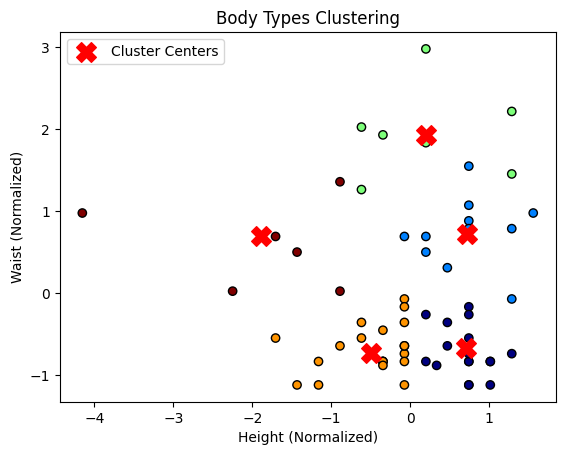

In [531]:
plt.scatter(model_stats[:, 0], model_stats[:, 2], c=labels, cmap='jet', edgecolors='k')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.xlabel('Height (Normalized)')
plt.ylabel('Waist (Normalized)')
plt.title('Body Types Clustering')
plt.legend()
plt.show()

In [532]:
kmeans.fit(tops_stats)

/home/schecter/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/schecter/.local/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


KMeans(n_clusters=5, random_state=42)

In [533]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
tops['cluster'] = labels

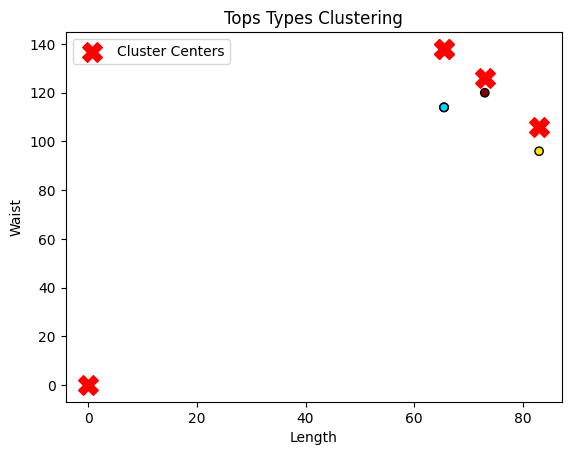

In [534]:
plt.scatter(tops_stats[:, 0], tops_stats[:, 2], c=labels, cmap='jet', edgecolors='k')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.xlabel('Length')
plt.ylabel('Waist')
plt.title('Tops Types Clustering')
plt.legend()
plt.show()

In [535]:
kmeans.fit(onepiece_stats)

/home/schecter/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [536]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
onepiece['cluster'] = labels

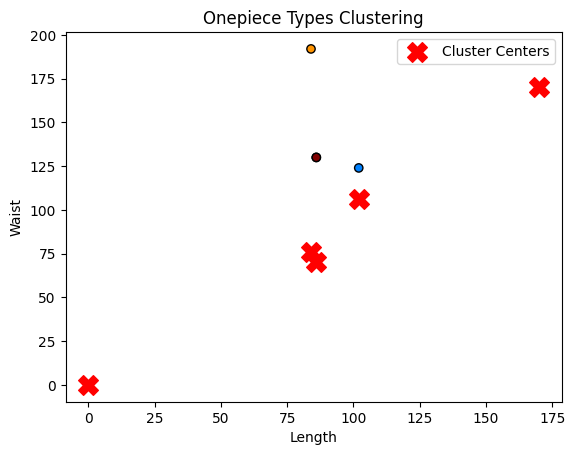

In [537]:
plt.scatter(onepiece_stats[:, 0], onepiece_stats[:, 2], c=labels, cmap='jet', edgecolors='k')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.xlabel('Length')
plt.ylabel('Waist')
plt.title('Onepiece Types Clustering')
plt.legend()
plt.show()

In [542]:
models.index

Index(['Alex', 'Amanda', 'Anna', 'Anna Maria', 'Anneliese', 'Bree',
       'Charlotte', 'Chesska', 'Chelsea', 'Clementine', 'Denniel', 'Edith',
       'Emma_1', 'Emma_2', 'Fiona', 'Gemma', 'Georgia', 'Grazi', 'Helen',
       'Jess', 'Jira', 'Jude', 'Kate', 'Katie', 'Lara', 'Laura', 'Lauren',
       'Lisa', 'Ljubenka', 'Louise', 'Lucy', 'Maddy_1', 'Maddy_2', 'Madeline',
       'Mae-Lee', 'Mandy', 'Marnee', 'Mercy', 'Miranda', 'Monique', 'Nadine',
       'Natalia', 'Natalie_1', 'Natalie_2', 'Nathalie_1', 'Nathalie_2',
       'Nikki', 'Olivia', 'Palatina', 'Perrie', 'Riina', 'Rosaline', 'Shadae',
       'Shanaya', 'Sophia ', 'Sophie', 'Stacey', 'Stefania', 'Summer', 'Thais',
       'Tia'],
      dtype='object')

In [550]:
for cluster_label, cluster_group in models.groupby('cluster'):
    sampled_images = cluster_group.sample(min(3, len(cluster_group)), random_state=42)

    # Plot the sampled images in the corresponding cluster subplot
    for i, (_, row) in enumerate(sampled_images.iterrows()):
        print((row))

height     178.0
bust        86.0
waist       67.0
hips        89.0
cluster        0
Name: Amanda, dtype: object
height     179.0
bust        84.0
waist       64.0
hips        90.0
cluster        0
Name: Anna Maria, dtype: object
height     176.0
bust        86.5
waist       70.0
hips        91.5
cluster        0
Name: Gemma, dtype: object
height     176.0
bust        92.0
waist       80.0
hips        98.0
cluster        1
Name: Louise, dtype: object
height     180.0
bust        99.0
waist       72.0
hips       107.0
cluster        1
Name: Bree, dtype: object
height     175.0
bust        96.0
waist       80.0
hips       107.0
cluster        1
Name: Rosaline, dtype: object
height     180.0
bust       112.0
waist       88.0
hips       128.0
cluster        2
Name: Lauren, dtype: object
height     180.0
bust       104.0
waist       96.0
hips       121.0
cluster        2
Name: Ljubenka, dtype: object
height     176.0
bust       113.0
waist      104.0
hips       132.0
cluster        2
Name: 

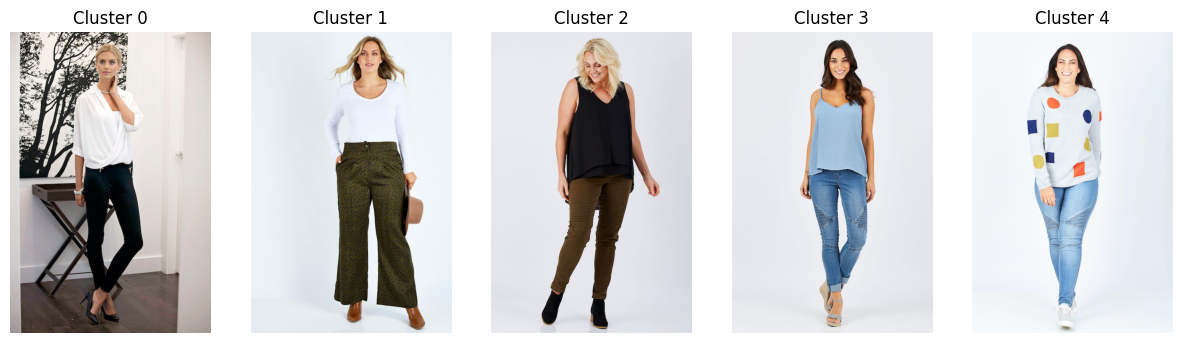

In [558]:
sample = 3
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

for cluster_label, cluster_group in models.groupby('cluster'):
    sampled_indices = cluster_group.sample(min(5, len(cluster_group)), random_state=42).index

    for i, index in enumerate(sampled_indices):
        img_path = os.path.join(MODELPATH, f'images/{index}.png')
        img = Image.open(img_path)

        ax[cluster_label].imshow(img)
        ax[cluster_label].axis("off")
        ax[cluster_label].set_title(f"Cluster {cluster_label}")

# Show the plot
plt.show()

## Embeddings
### hmeas

In [553]:
model_dict

{'Alex': {'height': '174.0', 'bust': '81.0', 'waist': '64.0', 'hips': '91.0'},
 'Amanda': {'height': '178.0',
  'bust': '86.0',
  'waist': '67.0',
  'hips': '89.0'},
 'Anna': {'height': '175.0', 'bust': '84.0', 'waist': '72.0', 'hips': '98.0'},
 'Anna Maria': {'height': '179.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '90.0'},
 'Anneliese': {'height': '178.0',
  'bust': '84.0',
  'waist': '64.0',
  'hips': '91.0'},
 'Bree': {'height': '180.0', 'bust': '99.0', 'waist': '72.0', 'hips': '107.0'},
 'Charlotte': {'height': '169.0',
  'bust': '88.0',
  'waist': '67.0',
  'hips': '93.0'},
 'Chesska': {'height': '173.0',
  'bust': '89.0',
  'waist': '69.0',
  'hips': '94.0'},
 'Chelsea': {'height': '177.0',
  'bust': '84.0',
  'waist': '69.0',
  'hips': '96.0'},
 'Clementine': {'height': '175.0',
  'bust': '86.0',
  'waist': '65.0',
  'hips': '91.0'},
 'Denniel': {'height': '178.0',
  'bust': '94.0',
  'waist': '71.0',
  'hips': '91.0'},
 'Edith': {'height': '175.0',
  'bust': '84.0',
 

In [554]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [559]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [560]:
def lr_sched(epoch):
    if epoch == 100:
        return 0.003 * 0.3
    elif epoch == 130:
        return 0.003 * 0.3 * 0.3
    else:
        return 0.003

In [561]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [564]:
# train the encoder
h_meas = model.predict(model_stats)

2/2 [==============================] - 0s 2ms/step


### hcnn

In [565]:
tops = "dataset/tops/images/"
onepiece = "dataset/onepiece/images/"

In [566]:
#define
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg'
)
model = tf.keras.models.Sequential([
    resnet,
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 28310664 (108.00 MB)
Trainable params: 28257544 (107.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [567]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [568]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [571]:
tops_image = [os.path.join(TOPSPATH, "images", f) for f in os.listdir(os.path.join(TOPSPATH, "images/")) if f.endswith('.png')]
onepiece_image = [os.path.join(ONEPIECEPATH, "images/", f) for f in os.listdir(os.path.join(ONEPIECEPATH, "images/")) if f.endswith('.png')]

In [573]:
target_size = (224, 224)
batch_size = 32

In [574]:
tops = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in tops_image]
onepiece = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in onepiece_image]

In [575]:
tops = np.array(tops)
tops = tf.keras.applications.resnet50.preprocess_input(tops)

In [576]:
tops_embeddings = model.predict(tops)

33/33 [==============================] - 5s 85ms/step


In [577]:
onepiece = np.array(onepiece)
onepiece = tf.keras.applications.resnet50.preprocess_input(onepiece)

In [578]:
onepiece_embeddings = model.predict(onepiece)

32/32 [==============================] - 4s 105ms/step


In [579]:
h_cnn_tops = tops_embeddings

In [580]:
h_cnn_onepiece = onepiece_embeddings

### hattr

In [581]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schecter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/schecter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [582]:
def generate_vocabulary(folder_path):
    vocabulary = set()
    stop_words = set(stopwords.words('english'))

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                description = file.read()
                tokens = word_tokenize(description.lower())
                tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
                vocabulary.update(tokens)

    return vocabulary

In [583]:
def bin_array(folder_path, vocabulary):
    binary_arrays = []
    i = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            i += 1
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                description = file.read()
                tokens = word_tokenize(description.lower())
                binary_array = [1 if attr in tokens else 0 for attr in vocabulary]
                binary_arrays.append(binary_array)
    print(i)

    return binary_arrays

In [584]:
meta_descr = os.path.join(TOPSPATH, "meta_descriptions/")
vocabulary = generate_vocabulary(meta_descr)
print(len(vocabulary))
binary_arrays = bin_array(meta_descr, vocabulary)
print(len(binary_arrays))
binary_arrays = np.array(binary_arrays)
print(binary_arrays.shape)

841
1056
1056
(1056, 841)


In [585]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(binary_arrays.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                53888     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
Total params: 56232 (219.66 KB)
Trainable params: 56232 (219.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [586]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [587]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [588]:
h_attr = model.predict(binary_arrays)

33/33 [==============================] - 0s 844us/step


### hbody

In [590]:
h_images = [img for img in os.listdir(os.path.join(MODELPATH, "images/")) if img.endswith('.png')]

In [593]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [592]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [597]:
# STEP 2: Create an PoseLandmarker object.
body_points = []

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

for img in h_images:
    image = mp.Image.create_from_file(os.path.join(MODELPATH, "images", img))
    dect = detector.detect(image)
    temp = dect.pose_landmarks[0]
    
    body_points.append([[temp[11].x, temp[11].y, temp[11].z, temp[11].visibility],# left shoulder
                        [temp[12].x, temp[12].y, temp[12].z, temp[12].visibility],# right shoulder
                        [temp[13].x, temp[13].y, temp[13].z, temp[13].visibility],# left elbow
                        [temp[14].x, temp[14].y, temp[14].z, temp[14].visibility],# right elbow
                        [temp[23].x, temp[23].y, temp[23].z, temp[23].visibility],# left hip
                        [temp[24].x, temp[24].y, temp[24].z, temp[24].visibility],# right hip
                        [temp[25].x, temp[25].y, temp[25].z, temp[25].visibility],# left knee
                        [temp[26].x, temp[26].y, temp[26].z, temp[26].visibility]])# right knee)

body_points

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

I0000 00:00:1702608889.278649   10634 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (se

[[[0.6507657766342163,
   0.20992174744606018,
   -0.19583913683891296,
   0.9999693632125854],
  [0.38974064588546753,
   0.21875670552253723,
   -0.32637882232666016,
   0.9999374151229858],
  [0.6847103238105774,
   0.3464975357055664,
   -0.012873601168394089,
   0.9545461535453796],
  [0.24927037954330444,
   0.30400362610816956,
   -0.3322998583316803,
   0.9630401134490967],
  [0.5918337106704712,
   0.4727972149848938,
   0.0698886588215828,
   0.9998621940612793],
  [0.43762657046318054,
   0.471868097782135,
   -0.07041363418102264,
   0.9998565912246704],
  [0.6208893656730652,
   0.688183069229126,
   0.07530511170625687,
   0.771706223487854],
  [0.4347362220287323,
   0.6778489947319031,
   -0.099479079246521,
   0.8304658532142639]],
 [[0.6712377071380615,
   0.19849979877471924,
   0.06928212195634842,
   0.9999414682388306],
  [0.4205969572067261,
   0.19682300090789795,
   0.157220259308815,
   0.9999277591705322],
  [0.715120255947113,
   0.338738352060318,
   -0.194

In [598]:
body_points = np.array(body_points)
body_points.shape

(61, 8, 4)

In [604]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(body_points.shape[1], body_points.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8, 32)             160       
                                                                 
 dense_13 (Dense)            (None, 8, 8)              264       
                                                                 
 dense_14 (Dense)            (None, 8, 4)              36        
                                                                 
Total params: 460 (1.80 KB)
Trainable params: 460 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [600]:
adam_opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003, decay=0.01)
model.compile(optimizer=adam_opt, loss='mse')

In [601]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_sched)

In [602]:
model.fit(body_points, body_points, epochs=180, callbacks=[lr_callback])

Epoch 1/180
2/2 [==============================] - 0s 6ms/step - loss: 0.3432 - lr: 0.0030
Epoch 2/180
2/2 [==============================] - 0s 3ms/step - loss: 0.3105 - lr: 0.0030
Epoch 3/180
2/2 [==============================] - 0s 4ms/step - loss: 0.2760 - lr: 0.0030
Epoch 4/180
2/2 [==============================] - 0s 4ms/step - loss: 0.2434 - lr: 0.0030
Epoch 5/180
2/2 [==============================] - 0s 4ms/step - loss: 0.2141 - lr: 0.0030
Epoch 6/180
2/2 [==============================] - 0s 4ms/step - loss: 0.1879 - lr: 0.0030
Epoch 7/180
2/2 [==============================] - 0s 5ms/step - loss: 0.1640 - lr: 0.0030
Epoch 8/180
2/2 [==============================] - 0s 4ms/step - loss: 0.1429 - lr: 0.0030
Epoch 9/180
2/2 [==============================] - 0s 4ms/step - loss: 0.1250 - lr: 0.0030
Epoch 10/180
2/2 [==============================] - 0s 4ms/step - loss: 0.1100 - lr: 0.0030
Epoch 11/180
2/2 [==============================] - 0s 3ms/step - loss: 0.0981 - lr: 0.00

In [603]:
h_body = model.predict(body_points)

2/2 [==============================] - 0s 2ms/step
